Loading elevation data...
Loaded: (2011, 2334) pixels (360m resolution)
Elevation range: -19.0m to 3405.0m
Calculating D8 flow directions...
   Processing flow directions...


   Flow direction rows: 100%|██████████| 2009/2009 [00:16<00:00, 119.51it/s]


Flow directions calculated
Calculating flow accumulation...
   Accumulating flow (5 iterations)...


   Flow accumulation: 100%|██████████| 5/5 [00:37<00:00,  7.60s/it]


Flow accumulation calculated
Calculating slope...
   Slope calculated:
   Mean: 2.31°
   Max: 53.38°
   95th percentile: 12.95°
Calculating Topographic Wetness Index...
   TWI calculated:
   Mean: 14.81
   Range: 5.72 to 21.55
   95th percentile: 18.63
Finding optimal drainage threshold...
   Flow accumulation statistics:
     Min: 1.0
     Max: 150.0
     Mean: 6.0
     Median: 6.0
   Testing drainage thresholds:
     85th percentile (6): 403,501 pixels (8.60%)
     90th percentile (6): 403,501 pixels (8.60%)
     92th percentile (7): 371,741 pixels (7.92%)
     95th percentile (15): 233,510 pixels (4.97%)
     97th percentile (24): 140,410 pixels (2.99%)
     98th percentile (31): 92,921 pixels (1.98%)
     99th percentile (45): 45,384 pixels (0.97%)
   Selected threshold: 15
   Drainage pixels: 233,510 (4.97%)
Calculating HAND with threshold 15...
   Drainage network: 233,510 pixels
   Calculating distance to drainage...
   Calculating HAND values...
   Processing 4,460,164 non-drai

   HAND calculation: 100%|██████████| 224/224 [04:25<00:00,  1.19s/it]


   HAND completed:
   Mean: 93.5m
   Max: 1874.0m
   Valid pixels: 2,170,533

STEP 2: LOADING FLOOD MAPS
------------------------------
Loading 2-year flood map...
   294,107 flood pixels
Loading 5-year flood map...
   341,977 flood pixels
Loading 10-year flood map...
   327,292 flood pixels
Loading 25-year flood map...
   341,977 flood pixels
Loading 50-year flood map...
   351,617 flood pixels
Loading 100-year flood map...
   361,613 flood pixels
Loading 500-year flood map...
   380,459 flood pixels
Loading 1000-year flood map...
   386,948 flood pixels
Loaded 8 flood maps successfully

STEP 3: FLOOD MODELING

Processing: 4649 segments with 0-year RP...
   Using minimal flood potential for normal flow
Creating river network with variable width (based on stream order)...
   Buffering river segments by stream order...
   Successfully buffered 4649 segments
   Rasterizing river network...
   River network created:
   River pixels: 15,032
   Coverage: 0.320%
   River network: 15,032 pixe

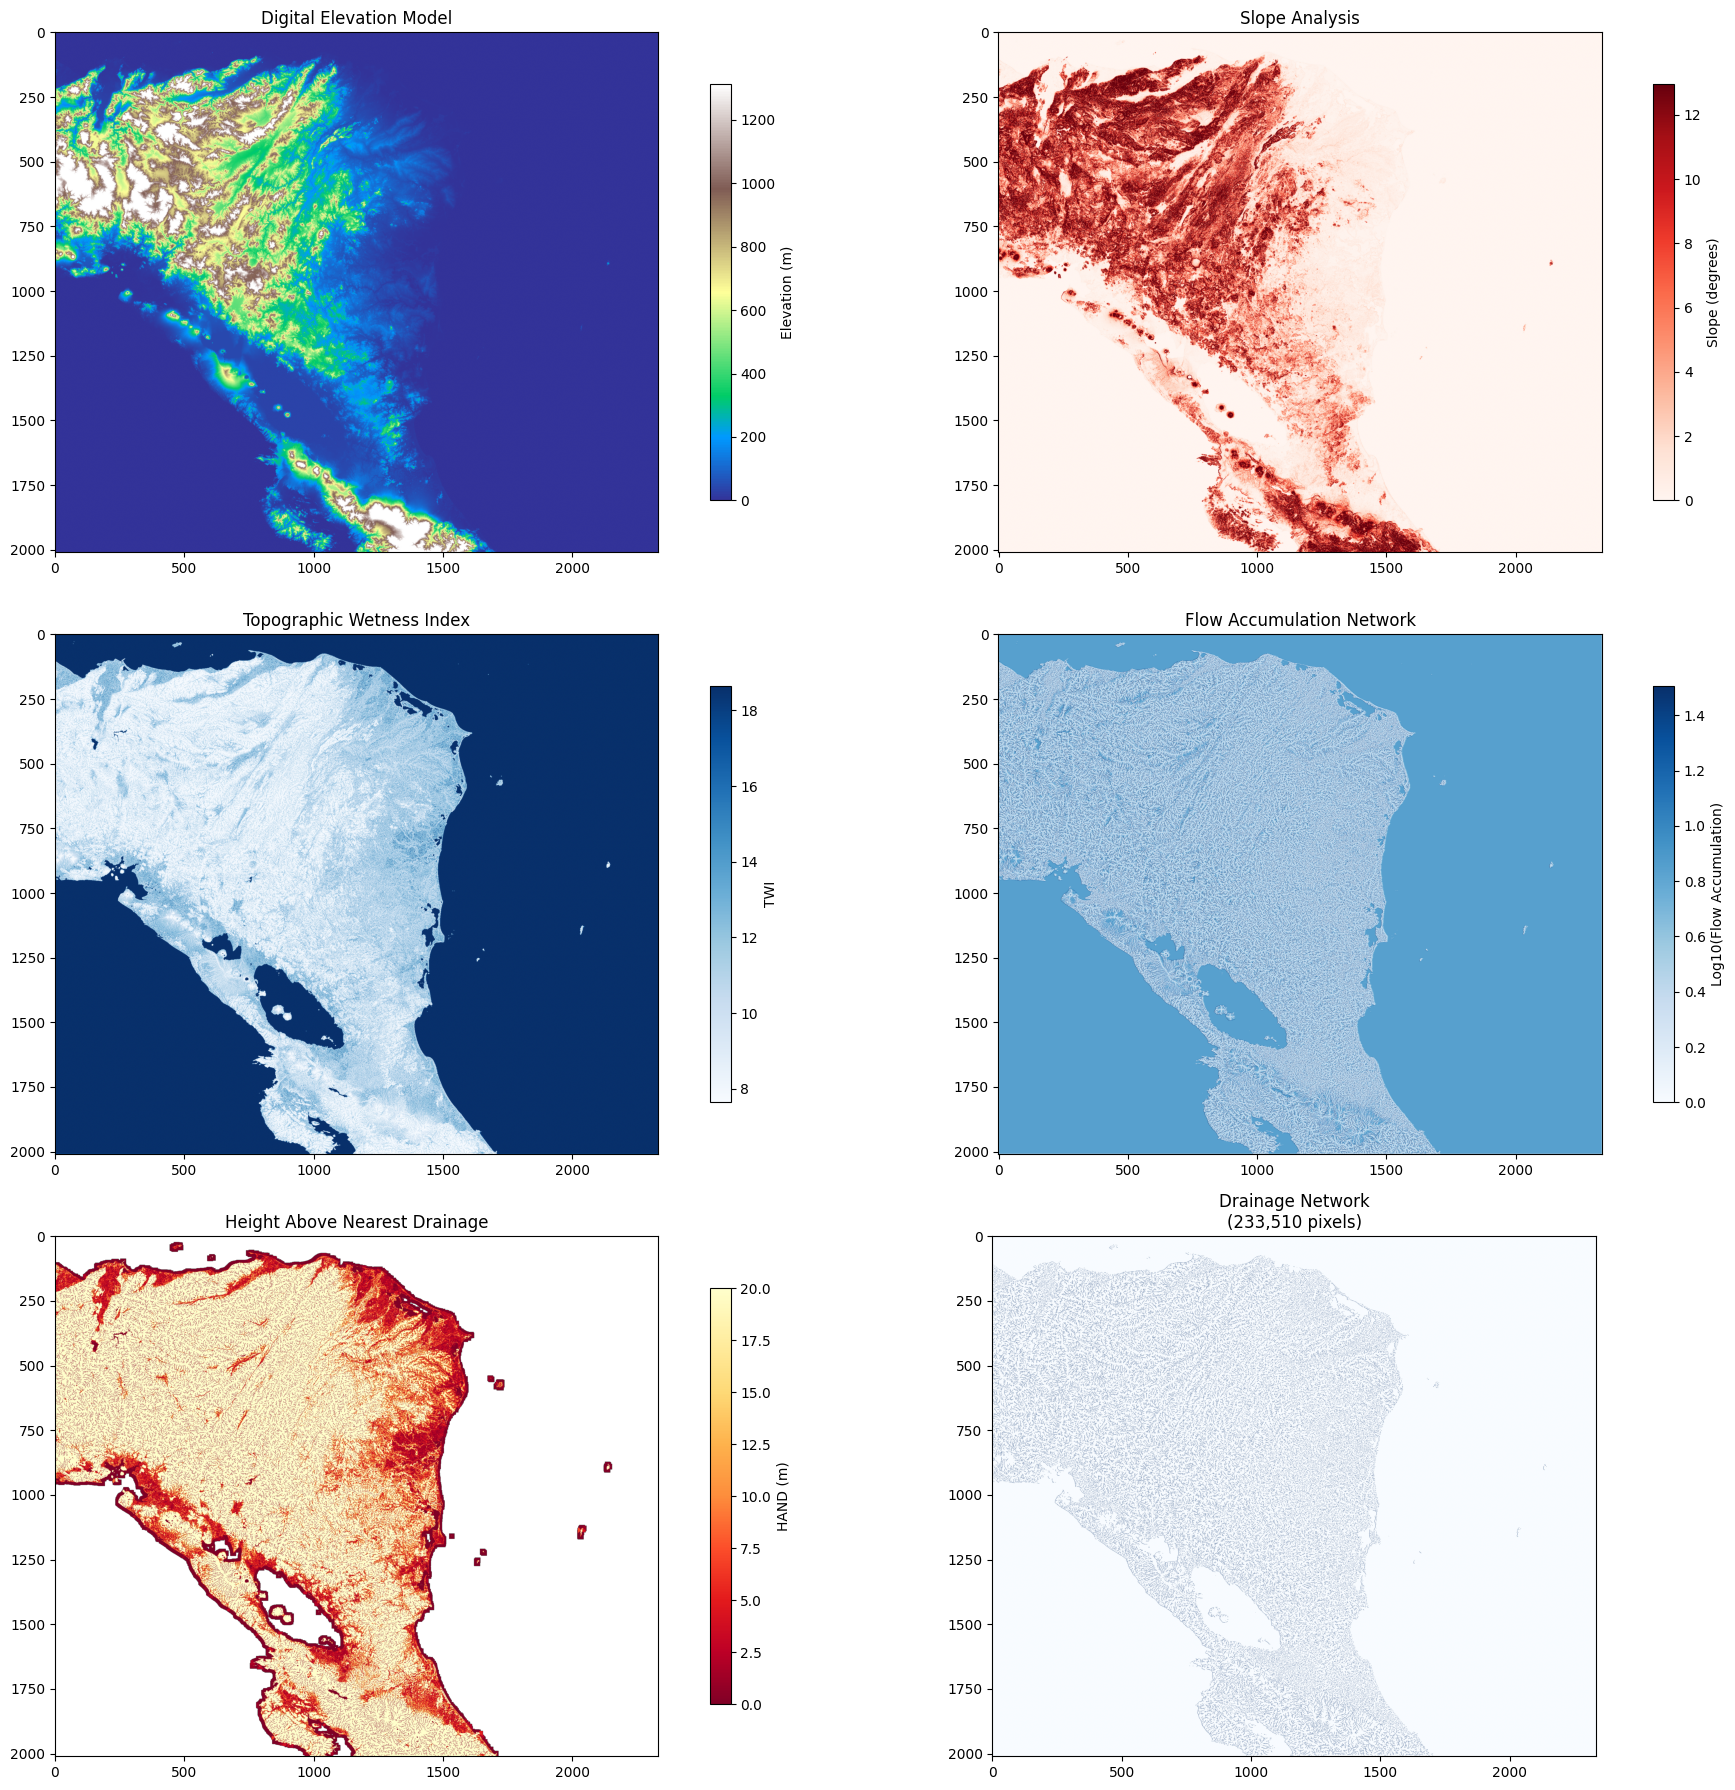

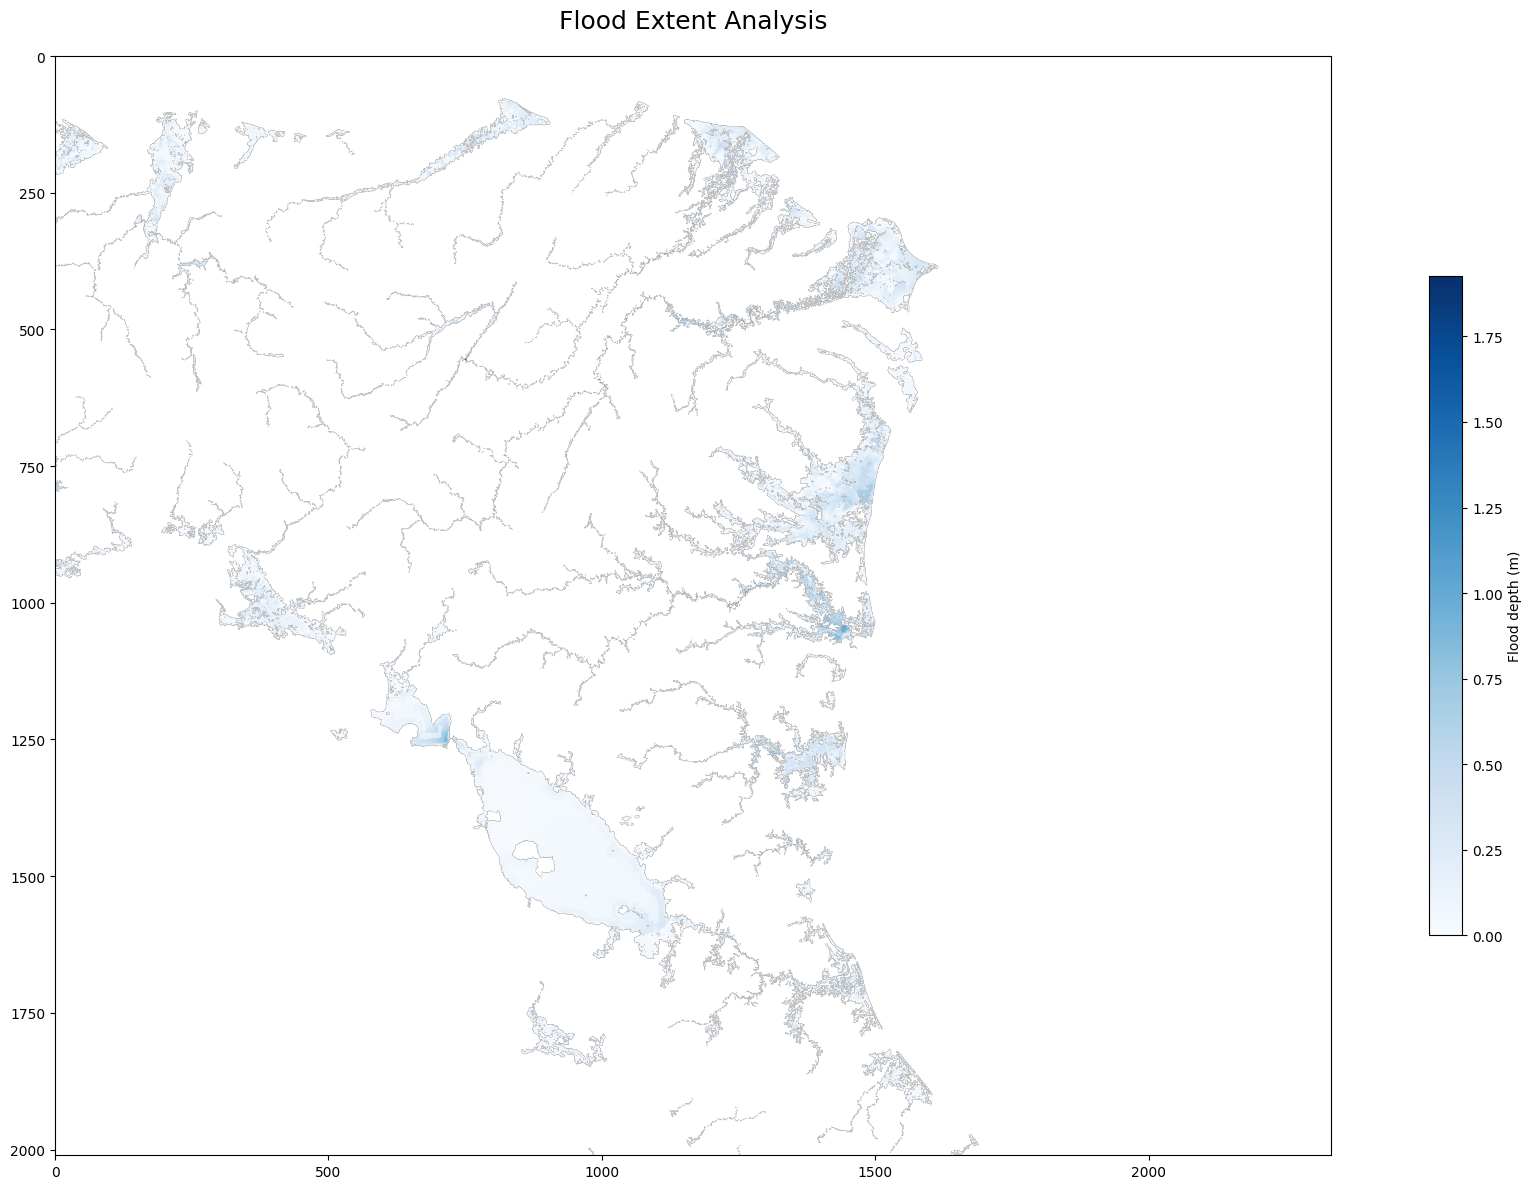

Saved flood extent: nicaragua_flood_4x_extent.tif


In [3]:
###############################################################################################
### IMPORTS
###############################################################################################
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.features import rasterize
from scipy.ndimage import distance_transform_edt, binary_dilation
from scipy import ndimage
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')


###############################################################################################
### CONFIGURATIONS
###############################################################################################
DOWNSAMPLE_FACTOR = 4               # 1=full resolution (slow), 2=balanced, 4=fast


###############################################################################################
### TERRAIN ANALYSIS
###############################################################################################
def load_elevation_data(downsample_factor):
    """Load elevation data with optional downsampling"""
    print(f"Loading elevation data...")

    with rasterio.open('srtm_90m_dem_nic.tif') as src:
        if downsample_factor == 1:
            elevation = src.read(1)
            transform = src.transform
        else:
            elevation = src.read(1)[::downsample_factor, ::downsample_factor]
            transform = rasterio.Affine(
                src.transform[0] * downsample_factor,
                src.transform[1], src.transform[2],
                src.transform[3],
                src.transform[4] * downsample_factor,
                src.transform[5]
            )

        crs = src.crs
        bounds = src.bounds

        # Clean elevation data
        elevation = np.where(elevation == src.nodata, np.nan, elevation)
        elevation = np.where(elevation == -32768, np.nan, elevation)
        elevation = np.where(elevation < -100, np.nan, elevation)

    resolution = 90 * downsample_factor
    print(f"Loaded: {elevation.shape} pixels ({resolution}m resolution)")
    print(f"Elevation range: {np.nanmin(elevation):.1f}m to {np.nanmax(elevation):.1f}m")

    return elevation, transform, crs, bounds

def calculate_slope(elevation, resolution=90):
    """Calculate slope in degrees from elevation DEM"""
    print("Calculating slope...")

    # Calculate gradients using numpy gradient
    grad_y, grad_x = np.gradient(elevation)

    # Convert to slope in degrees
    slope_radians = np.arctan(np.sqrt(grad_x**2 + grad_y**2) / resolution)
    slope_degrees = np.degrees(slope_radians)

    # Handle NaN values
    slope_degrees = np.where(np.isnan(elevation), np.nan, slope_degrees)

    slope_stats = slope_degrees[~np.isnan(slope_degrees)]
    print(f"   Slope calculated:")
    print(f"   Mean: {np.mean(slope_stats):.2f}°")
    print(f"   Max: {np.max(slope_stats):.2f}°")
    print(f"   95th percentile: {np.percentile(slope_stats, 95):.2f}°")

    return slope_degrees

def calculate_topographic_wetness_index(elevation, flow_acc, slope_degrees, resolution=90):
    """Calculate Topographic Wetness Index (TWI)"""
    print("Calculating Topographic Wetness Index...")

    # Convert slope to radians and add small value to avoid division by zero
    slope_radians = np.radians(slope_degrees + 0.001)

    # Calculate specific catchment area (flow accumulation * resolution / contour length)
    specific_catchment_area = flow_acc * resolution

    # Calculate TWI: ln(a/tan(β)) where a is specific catchment area, β is slope
    twi = np.log(specific_catchment_area / np.tan(slope_radians))

    # Handle invalid values
    twi = np.where(np.isnan(elevation), np.nan, twi)
    twi = np.where(np.isinf(twi), np.nan, twi)

    twi_stats = twi[~np.isnan(twi)]
    print(f"   TWI calculated:")
    print(f"   Mean: {np.mean(twi_stats):.2f}")
    print(f"   Range: {np.min(twi_stats):.2f} to {np.max(twi_stats):.2f}")
    print(f"   95th percentile: {np.percentile(twi_stats, 95):.2f}")

    return twi

def calculate_flow_direction_d8(elevation):
    """Calculate D8 flow direction with progress tracking"""
    print("Calculating D8 flow directions...")

    rows, cols = elevation.shape
    flow_dir = np.zeros_like(elevation, dtype=np.uint8)

    # D8 directions: E, SE, S, SW, W, NW, N, NE
    directions = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]
    direction_codes = [1, 2, 4, 8, 16, 32, 64, 128]

    print("   Processing flow directions...")
    for i in tqdm(range(1, rows-1), desc="   Flow direction rows"):
        for j in range(1, cols-1):
            if np.isnan(elevation[i, j]):
                continue

            center_elev = elevation[i, j]
            max_slope = -999
            best_direction = 0

            # Check all 8 neighbors
            for k, (di, dj) in enumerate(directions):
                ni, nj = i + di, j + dj
                if not np.isnan(elevation[ni, nj]):
                    slope = center_elev - elevation[ni, nj]
                    if slope > max_slope:
                        max_slope = slope
                        best_direction = direction_codes[k]

            flow_dir[i, j] = best_direction

    print("Flow directions calculated")
    return flow_dir

def calculate_flow_accumulation(flow_dir, elevation):
    """Calculate flow accumulation with progress tracking"""
    print("Calculating flow accumulation...")

    rows, cols = flow_dir.shape
    flow_acc = np.ones_like(flow_dir, dtype=np.float32)

    # Direction mappings
    direction_map = {1: (0, 1), 2: (1, 1), 4: (1, 0), 8: (1, -1),
                     16: (0, -1), 32: (-1, -1), 64: (-1, 0), 128: (-1, 1)}

    # Iterative accumulation
    print("   Accumulating flow (5 iterations)...")
    for iteration in tqdm(range(5), desc="   Flow accumulation"):
        new_flow_acc = flow_acc.copy()

        for i in range(1, rows-1):
            for j in range(1, cols-1):
                if flow_dir[i, j] == 0 or np.isnan(elevation[i, j]):
                    continue

                # Find cells that flow into this cell
                total_inflow = 1  # Self contribution

                for source_dir, (di, dj) in direction_map.items():
                    si, sj = i - di, j - dj
                    if (0 <= si < rows and 0 <= sj < cols and
                        flow_dir[si, sj] == source_dir and
                        not np.isnan(elevation[si, sj])):
                        total_inflow += flow_acc[si, sj]

                new_flow_acc[i, j] = total_inflow

        flow_acc = new_flow_acc

    print("Flow accumulation calculated")
    return flow_acc

def find_optimal_drainage_threshold(flow_acc):
    """Automatically find optimal drainage threshold"""
    print("Finding optimal drainage threshold...")

    # Get statistics on flow accumulation
    flow_acc_stats = flow_acc[~np.isnan(flow_acc)]

    print(f"   Flow accumulation statistics:")
    print(f"     Min: {np.min(flow_acc_stats):.1f}")
    print(f"     Max: {np.max(flow_acc_stats):.1f}")
    print(f"     Mean: {np.mean(flow_acc_stats):.1f}")
    print(f"     Median: {np.median(flow_acc_stats):.1f}")

    # Test different percentile thresholds
    test_percentiles = [85, 90, 92, 95, 97, 98, 99]
    best_threshold = None

    print(f"   Testing drainage thresholds:")
    for percentile in test_percentiles:
        threshold = np.percentile(flow_acc_stats, percentile)
        drainage_pixels = np.sum(flow_acc > threshold)
        percentage = drainage_pixels / flow_acc.size * 100

        print(f"     {percentile}th percentile ({threshold:.0f}): {drainage_pixels:,} pixels ({percentage:.2f}%)")

        # Good drainage network should be 0.5-5% of total area
        if 0.5 <= percentage <= 5.0 and best_threshold is None:
            best_threshold = threshold

    # Fallback if no good threshold found
    if best_threshold is None:
        best_threshold = np.percentile(flow_acc_stats, 90)
        print(f"   Using fallback: 90th percentile ({best_threshold:.0f})")

    drainage_pixels = np.sum(flow_acc > best_threshold)
    drainage_pct = drainage_pixels / flow_acc.size * 100

    print(f"   Selected threshold: {best_threshold:.0f}")
    print(f"   Drainage pixels: {drainage_pixels:,} ({drainage_pct:.2f}%)")

    return best_threshold

def calculate_hand_efficient(elevation, flow_acc, threshold):
    """Calculate HAND efficiently with proper drainage network"""
    print(f"Calculating HAND with threshold {threshold:.0f}...")

    # Create drainage network
    drainage_mask = flow_acc > threshold
    drainage_count = np.sum(drainage_mask)

    print(f"   Drainage network: {drainage_count:,} pixels")

    if drainage_count == 0:
        print("   ERROR: Still no drainage pixels!")
        # Emergency fallback - use top 5%
        emergency_threshold = np.percentile(flow_acc[~np.isnan(flow_acc)], 95)
        drainage_mask = flow_acc > emergency_threshold
        drainage_count = np.sum(drainage_mask)
        print(f"   Emergency fallback: {drainage_count:,} pixels")

    # Calculate distance to drainage
    print("   Calculating distance to drainage...")
    distance_to_drainage = distance_transform_edt(~drainage_mask)

    # Initialize HAND
    hand = np.full_like(elevation, np.nan)

    # Set drainage pixels to HAND = 0
    hand[drainage_mask] = 0

    # Calculate HAND for non-drainage pixels efficiently
    print("   Calculating HAND values...")
    non_drainage_mask = ~drainage_mask & ~np.isnan(elevation)
    non_drainage_count = np.sum(non_drainage_mask)

    print(f"   Processing {non_drainage_count:,} non-drainage pixels...")

    # Get indices of non-drainage pixels
    non_drainage_indices = np.where(non_drainage_mask)
    rows, cols = elevation.shape

    # Process in batches with progress tracking
    batch_size = 20000
    total_batches = (len(non_drainage_indices[0]) + batch_size - 1) // batch_size

    for batch_idx in tqdm(range(total_batches), desc="   HAND calculation"):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(non_drainage_indices[0]))

        for idx in range(start_idx, end_idx):
            i, j = non_drainage_indices[0][idx], non_drainage_indices[1][idx]

            # Find nearest drainage elevation
            dist = int(distance_to_drainage[i, j])
            search_radius = min(dist + 2, 10)  # Reasonable search limit

            min_drainage_elev = np.inf

            for di in range(-search_radius, search_radius + 1):
                for dj in range(-search_radius, search_radius + 1):
                    ni, nj = i + di, j + dj
                    if (0 <= ni < rows and 0 <= nj < cols and
                        drainage_mask[ni, nj] and not np.isnan(elevation[ni, nj])):
                        min_drainage_elev = min(min_drainage_elev, elevation[ni, nj])

            if min_drainage_elev != np.inf:
                hand[i, j] = max(0, elevation[i, j] - min_drainage_elev)

    # Calculate final statistics
    hand_stats = hand[~np.isnan(hand)]
    if len(hand_stats) > 0:
        print(f"   HAND completed:")
        print(f"   Mean: {np.mean(hand_stats):.1f}m")
        print(f"   Max: {np.max(hand_stats):.1f}m")
        print(f"   Valid pixels: {len(hand_stats):,}")

    return hand, drainage_mask


###############################################################################################
### RIVER NETWORK CREATION
###############################################################################################
def create_river_network_raster(segments, shape, transform, crs, river_width_m=None):
    """
    Create river network raster with width based on stream order if available,
    otherwise fallback to fixed river_width_m.
    """
    print(f"Creating river network with variable width (based on stream order)...")

    try:
        # Reproject segments to elevation CRS
        segments_reproj = segments.to_crs(crs)

        # Define mapping from stream order to width (in meters)
        def stream_order_to_width(order):
            if order <= 1:
                return 5
            elif order == 2:
                return 10
            elif order == 3:
                return 20
            elif order == 4:
                return 40
            elif order == 5:
                return 60
            elif order == 6:
                return 100
            elif order == 7:
                return 150
            elif order == 8:
                return 250
            else:
                return 60

        # Buffer segments with variable width
        buffered_segments = []

        print("   Buffering river segments by stream order...")
        for idx, row in segments_reproj.iterrows():
            try:
                geom = row.geometry
                if geom is None or geom.is_empty:
                    continue

                if 'streamorder' in row and not pd.isna(row['streamorder']):
                    width = stream_order_to_width(int(row['streamorder']))
                elif river_width_m is not None:
                    width = river_width_m
                else:
                    width = 60  # Default fallback

                radius = width / 2.0
                buffered_geom = geom.buffer(radius)
                if buffered_geom.is_empty:
                    buffered_geom = geom.centroid.buffer(radius)

                buffered_segments.append(buffered_geom)

            except Exception as e:
                print(f"   Failed to buffer segment {idx}: {e}")
                continue

        if not buffered_segments:
            print("   No valid buffered segments created")
            return np.zeros(shape, dtype=np.uint8)

        print(f"   Successfully buffered {len(buffered_segments)} segments")

        # Rasterize buffered river network
        print("   Rasterizing river network...")
        river_raster = rasterize(
            buffered_segments,
            out_shape=shape,
            transform=transform,
            fill=0,
            default_value=1,
            dtype=np.uint8
        )

        # Connectivity
        river_raster = binary_dilation(river_raster, iterations=1)

        river_pixels = np.sum(river_raster)
        coverage = river_pixels / (shape[0] * shape[1]) * 100

        print(f"   River network created:")
        print(f"   River pixels: {river_pixels:,}")
        print(f"   Coverage: {coverage:.3f}%")

        return river_raster

    except Exception as e:
        print(f"   Error creating river raster: {e}")
        return np.zeros(shape, dtype=np.uint8)


###############################################################################################
### FLOOD FILL ALGORITHM
###############################################################################################
def flood_fill_algorithm(elevation, hand, slope, twi, flood_depth,
                                river_network, exceeds_rp, resolution=90):
    """
    1. HAND thresholds based on Nobre et al. (2011)
    2. Distance limits based on Özay & Orhan (2023)
    3. Slope limits based on Özay & Orhan (2023)
    4. Science-based factor weighting based on Özay & Orhan (2023)
    """

    # Initialize flood extent
    flood_extent = np.zeros_like(elevation, dtype=np.float32)

    # 1. HAND Threshold - Nobre et al. (2011)
    base_hand_threshold = _calculate_hand_threshold(exceeds_rp)

    # 2. Distance Threshold - Özay & Orhan (2023)
    max_distance_m = _calculate_distance_threshold(exceeds_rp)

    # 3. Slope Threshold - Özay & Orhan (2023)
    slope_threshold = _calculate_slope_threshold(exceeds_rp)

    print(f"      HAND ≤ {base_hand_threshold:.1f}m (Nobre et al. 2011)")
    print(f"      Distance ≤ {max_distance_m/1000:.1f}km (Özay & Orhan (2023))")
    print(f"      Slope ≤ {slope_threshold:.1f}° (Özay & Orhan (2023))")

    # Calculate distance from river network (IN METERS)
    distance_from_rivers_m = distance_transform_edt(~river_network) * resolution

    # Create suitability map (Özay & Orhan (2023))
    suitability = _calculate_suitability(
        elevation, hand, slope, twi, flood_depth, distance_from_rivers_m,
        base_hand_threshold, max_distance_m, slope_threshold
    )

    if suitability is None:
        print("      No valid areas for suitability calculation")
        return flood_extent

    # Apply minimum thresholds
    min_suitability = 0.3
    flood_suitable = suitability >= min_suitability

    if not np.any(flood_suitable):
        print("      No suitable flood areas found")
        return flood_extent

    flood_extent = np.where(flood_suitable, flood_depth * suitability, 0)

    # Ensure connectivity
    flood_extent = flood_connectivity(flood_extent, river_network, elevation)

    # Ensure hydraulic connectivity to river network
    flood_pixels = np.sum(flood_extent > 0)
    flood_area_km2 = flood_pixels * (resolution/1000)**2
    print(f"      Flood area: {flood_area_km2:.1f} km² ({flood_pixels:,} pixels)")

    return flood_extent

def _calculate_hand_threshold(exceeds_rp):
    """
    Calculate HAND threshold based on flood zone classification.

    HAND-based flood zone classification:
    - HAND < 5m: Regularly flooded areas (high flood susceptibility)
    - HAND 5-15m: Intermediate zones with occasional flooding
    - HAND > 15m: Dry uplands, generally not flooded (low flood susceptibility)

    The threshold increases logarithmically with return period to account for
    more extreme floods reaching higher elevations.

    References:
    Nobre et al. (2011). Height Above the Nearest Drainage – a hydrologically relevant
    new terrain model. Journal of Hydrology, Vol. 404, Issues 1–2, Pages 13-29.
    """

    # Base threshold: transition from regularly flooded to intermediate zone
    base_threshold = 5.0  # meters

    # Maximum threshold: transition to dry uplands (even extreme floods rarely exceed this)
    max_threshold = 15.0  # meters

    # Scale logarithmically with return period
    if exceeds_rp <= 2:
        # Small floods stay in regularly flooded zone
        return base_threshold
    elif exceeds_rp >= 500:
        return max_threshold
    else:
        log_factor = np.log10(exceeds_rp) / np.log10(500)  # Scale to 500-year max
        hand_threshold = base_threshold + (max_threshold - base_threshold) * log_factor
        return np.clip(hand_threshold, base_threshold, max_threshold)

def _calculate_distance_threshold(exceeds_rp):
    """
    Calculate distance-to-river threshold based on flood susceptibility research.

    Distance classifications derived from GIS-based multi-criteria decision analysis
    using best-worst and logistic regression methods (Özay & Orhan, 2023).

    Classifications:
    - 0-200m: Highest flood susceptibility
    - 200-500m: High susceptibility
    - 500-1000m: Medium susceptibility
    - 1000-1500m: Low susceptibility
    - >1500m: Very low susceptibility

    References:
    Özay, B., & Orhan, O. (2023). Flood susceptibility mapping by best–worst and
    logistic regression methods in Mersin, Turkey. Environmental Science and
    Pollution Research, 30(15), 45151-45170.
    """
    base_distance = 200.0   # meters
    max_distance = 1500.0   # meters

    if exceeds_rp <= 2:
        return base_distance
    else:
        log_factor = np.log10(exceeds_rp) / np.log10(1000)
        distance_threshold = base_distance + (max_distance - base_distance) * log_factor
        return np.clip(distance_threshold, base_distance, max_distance)

def _calculate_slope_threshold(exceeds_rp):
    """
    Calculate slope threshold based on topographic factor analysis in flood modeling.

    Slope classifications derived from geomorphological flood susceptibility analysis
    using analytical hierarchy process (Özay & Orhan, 2023).

    Classifications (degrees):
    - 0-5°: Highest flood susceptibility
    - 5-10°: High susceptibility
    - 10-20°: Medium susceptibility
    - 20-35°: Low susceptibility
    - >35°: Very low susceptibility

    References:
    Özay, B., & Orhan, O. (2023). Flood susceptibility mapping by best–worst and
    logistic regression methods in Mersin, Turkey. Environmental Science and
    Pollution Research, 30(15), 45151-45170.
    """
    base_slope = 5.0    # degrees
    max_slope = 35.0    # degrees

    if exceeds_rp <= 2:
        return base_slope
    else:
        linear_factor = min(exceeds_rp / 500.0, 1.0)
        slope_threshold = base_slope + (max_slope - base_slope) * linear_factor
        return np.clip(slope_threshold, base_slope, max_slope)

def _calculate_suitability(elevation, hand, slope, twi, flood_depth,
                           distance_from_rivers_m, hand_threshold,
                           distance_threshold, slope_threshold):
    """
    Calculate flood suitability using multi-criteria decision analysis weights.

    Factor weights derived from best-worst method and analytical hierarchy process
    applied to flood susceptibility mapping (Özay & Orhan, 2023). Weights normalized
    for available parameters:

    - Elevation: 48.9% (most important factor)
    - Slope: 28.5% (second most important)
    - Distance to river: 20.4% (third most important)
    - Topographic wetness index: 2.3% (least important)

    The weighting scheme reflects the relative importance of each factor in determining
    flood susceptibility based on empirical analysis of historical flood events.

    References:
    Özay, B., & Orhan, O. (2023). Flood susceptibility mapping by best–worst and
    logistic regression methods in Mersin, Turkey. Environmental Science and
    Pollution Research, 30(15), 45151-45170.
    """

    # Valid areas: not NaN, has potential flood depth
    valid_base = (~np.isnan(elevation)) & (flood_depth > 0)

    if not np.any(valid_base):
        return None

    # Factor 1: HAND suitability (proxy for elevation effects)
    hand_factor = np.where(valid_base & (~np.isnan(hand)),
                          np.maximum(0, 1 - (hand / hand_threshold)), 0)

    # Factor 2: Distance suitability
    distance_factor = np.where(valid_base,
                              np.maximum(0, 1 - (distance_from_rivers_m / distance_threshold)), 0)

    # Factor 3: Slope suitability
    slope_factor = np.where(valid_base & (~np.isnan(slope)),
                           np.maximum(0, 1 - (slope / slope_threshold)), 0)

    # Factor 4: TWI suitability
    if twi is not None and not np.all(np.isnan(twi)):
        twi_valid = twi[~np.isnan(twi)]
        if len(twi_valid) > 0:
            twi_min, twi_max = np.percentile(twi_valid, [5, 95])
            twi_factor = np.where(valid_base & (~np.isnan(twi)),
                                 np.clip((twi - twi_min) / (twi_max - twi_min), 0, 1), 0)
        else:
            twi_factor = np.ones_like(elevation) * 0.5
    else:
        twi_factor = np.ones_like(elevation) * 0.5

    # Multi-criteria decision analysis weights (Özay & Orhan, 2023)
    # Normalized for available parameters
    ELEVATION_WEIGHT = 0.489    # 48.9% - Most important factor
    SLOPE_WEIGHT = 0.285        # 28.5% - Second most important
    DISTANCE_WEIGHT = 0.204     # 20.4% - Third most important
    TWI_WEIGHT = 0.023          # 2.3% - Least important

    # Verify weights sum to 1.0
    total_weight = ELEVATION_WEIGHT + SLOPE_WEIGHT + DISTANCE_WEIGHT + TWI_WEIGHT
    if abs(total_weight - 1.0) > 0.001:
        print(f"Warning: Weights sum to {total_weight}, normalizing...")
        ELEVATION_WEIGHT /= total_weight
        SLOPE_WEIGHT /= total_weight
        DISTANCE_WEIGHT /= total_weight
        TWI_WEIGHT /= total_weight


    # Combine factors with empirically-derived weights
    suitability = (
        hand_factor * ELEVATION_WEIGHT +     # 48.9% - Most important
        slope_factor * SLOPE_WEIGHT +        # 28.5% - Second most important
        distance_factor * DISTANCE_WEIGHT +  # 20.4% - Third most important
        twi_factor * TWI_WEIGHT             # 2.3% - Least important
    )

    return suitability

def flood_connectivity(flood_extent, river_network, elevation):
    """Flood connectivity using watershed-based approach"""

    # Create seeds from river network
    river_flood_seeds = river_network & (flood_extent > 0)

    if not np.any(river_flood_seeds):
        return flood_extent

    # Label connected components
    labeled_seeds, num_labels = ndimage.label(river_flood_seeds)

    if num_labels == 0:
        return flood_extent

    # Create watershed landscape
    elevation_for_watershed = np.where(np.isnan(elevation),
                                      np.nanmax(elevation) + 1000, elevation)
    watershed_landscape = -elevation_for_watershed

    # Apply watershed connectivity
    try:
        from skimage.segmentation import watershed
        watershed_result = watershed(watershed_landscape, labeled_seeds,
                                   mask=(flood_extent > 0))

        # Maintain connectivity
        flood = np.where(watershed_result > 0,
                        np.maximum(flood_extent, flood_extent.mean() * 0.3),
                        flood_extent)
        return flood

    except Exception as e:
        print(f"Warning: Watershed connectivity failed: {e}")
        return flood_extent


###############################################################################################
### FLOOD MAP LOADING
###############################################################################################
def load_and_reproject_all_flood_maps(elevation_shape, elevation_transform, elevation_crs):
    """Load and reproject all flood maps"""
    print("\nSTEP 2: LOADING FLOOD MAPS")
    print("-" * 30)

    return_periods = [2, 5, 10, 25, 50, 100, 500, 1000]
    flood_maps = {}

    for rp in return_periods:
        filename = f'nic_flood_CDRI_h{rp}.tif'
        print(f"Loading {rp}-year flood map...")

        try:
            with rasterio.open(filename) as src:
                flood_data = src.read(1)
                src_crs = src.crs if src.crs is not None else 'EPSG:4326'

                # Clean data
                flood_data = np.where(flood_data < 0, 0, flood_data)
                flood_data = np.where(flood_data > 2000, 0, flood_data)

                # Reproject to elevation grid
                reprojected = np.zeros(elevation_shape, dtype=np.float32)

                reproject(
                    source=flood_data,
                    destination=reprojected,
                    src_transform=src.transform,
                    src_crs=src_crs,
                    dst_transform=elevation_transform,
                    dst_crs=elevation_crs,
                    resampling=Resampling.bilinear
                )

                flood_maps[rp] = reprojected
                valid_pixels = np.sum(reprojected > 0)
                print(f"   {valid_pixels:,} flood pixels")

        except Exception as e:
            print(f"   Failed: {e}")
            continue

    print(f"Loaded {len(flood_maps)} flood maps successfully")
    return flood_maps

def create_flood_extents(discharge_gdf, flood_maps, elevation, hand, slope, twi,
                         drainage_mask, elevation_transform, elevation_crs, resolution=90):
    """Create flood extents using FIXED river network"""

    print(f"\nSTEP 3: FLOOD MODELING")

    # Initialize output maps
    output_flood_map = np.zeros_like(elevation, dtype=np.float32)

    # Process segments by exceeds_rp value
    rp_groups = discharge_gdf.groupby('exceeds_rp')

    for exceeds_rp, rp_segments in rp_groups:
        print(f"\nProcessing: {len(rp_segments)} segments with {exceeds_rp}-year RP...")

        if exceeds_rp == 0:
            # Normal flow - minimal flood potential
            if 2 in flood_maps:
                flood_map = flood_maps[2] * 0.05
                print("   Using minimal flood potential for normal flow")
            else:
                continue
        else:
            # At-risk segments - use appropriate flood map
            available_rps = [rp for rp in flood_maps.keys() if rp > 0]
            if not available_rps:
                continue

            closest_rp = min(available_rps, key=lambda x: abs(x - exceeds_rp))
            flood_map = flood_maps[closest_rp]
            print(f"   Using {closest_rp}-year flood map for {exceeds_rp}-year exceedance")

        # Create FIXED river network raster with uniform width
        river_network = create_river_network_raster(
            rp_segments, elevation.shape, elevation_transform, elevation_crs
        )

        river_pixels = np.sum(river_network)
        if river_pixels == 0:
            print("   No river network created")
            continue

        print(f"   River network: {river_pixels:,} pixels")

        # Apply flood modeling
        print("   Applying flood modeling...")
        segment_floods = flood_fill_algorithm(
            elevation, hand, slope, twi, flood_map, river_network, exceeds_rp
        )

        # Combine with output (take maximum)
        output_flood_map = np.maximum(output_flood_map, segment_floods)

        flood_pixels = np.sum(segment_floods > 0)
        print(f"   Added {flood_pixels:,} flood pixels")

    total_flood_pixels = np.sum(output_flood_map > 0)
    coverage = total_flood_pixels / output_flood_map.size * 100

    print(f"Total flood pixels: {total_flood_pixels:,}")
    print(f"Coverage: {coverage:.3f}% of study area")

    return output_flood_map


###############################################################################################
### VISUALIZATION
###############################################################################################
def visualize_results(elevation, flow_acc, hand, slope, twi, drainage_mask):
    """Comprehensive visualization of results - 3x2 grid only"""

    # Create figure with just 3x2 grid, using full space for larger plots
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

    ## Row 1: Elevation and Slope
    ax1 = axes[0, 0]
    elev_display = np.where(np.isnan(elevation), np.nan, elevation)
    im1 = ax1.imshow(elev_display, cmap='terrain', vmin=0, vmax=np.nanpercentile(elev_display, 98))
    plt.colorbar(im1, ax=ax1, label='Elevation (m)', shrink=0.8)
    ax1.set_title('Digital Elevation Model')

    ax2 = axes[0, 1]
    if slope is not None:
        slope_display = np.where(np.isnan(slope), np.nan, slope)
        im2 = ax2.imshow(slope_display, cmap='Reds', vmin=0, vmax=np.nanpercentile(slope_display, 95))
        plt.colorbar(im2, ax=ax2, label='Slope (degrees)', shrink=0.8)
        ax2.set_title('Slope Analysis')
    else:
        ax2.text(0.5, 0.5, 'Slope not calculated', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Slope Analysis (N/A)')

    ## Row 2: TWI and Flow Accumulation
    ax3 = axes[1, 0]
    if twi is not None:
        twi_display = np.where(np.isnan(twi), np.nan, twi)
        im3 = ax3.imshow(twi_display, cmap='Blues', vmin=np.nanpercentile(twi_display, 5),
                        vmax=np.nanpercentile(twi_display, 95))
        plt.colorbar(im3, ax=ax3, label='TWI', shrink=0.8)
        ax3.set_title('Topographic Wetness Index')
    else:
        ax3.text(0.5, 0.5, 'TWI not calculated', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('TWI (N/A)')

    ax4 = axes[1, 1]
    flow_acc_log = np.log10(flow_acc + 1)
    im4 = ax4.imshow(flow_acc_log, cmap='Blues', vmin=0, vmax=np.percentile(flow_acc_log, 98))
    plt.colorbar(im4, ax=ax4, label='Log10(Flow Accumulation)', shrink=0.8)
    ax4.set_title('Flow Accumulation Network')

    ## Row 3: HAND and Drainage Network
    ax5 = axes[2, 0]
    hand_display = np.where(np.isnan(hand), np.nan, np.clip(hand, 0, 50))
    im5 = ax5.imshow(hand_display, cmap='YlOrRd_r', vmin=0, vmax=20)
    plt.colorbar(im5, ax=ax5, label='HAND (m)', shrink=0.8)
    ax5.set_title('Height Above Nearest Drainage')

    ax6 = axes[2, 1]
    drainage_display = np.where(drainage_mask, 1, 0)
    ax6.imshow(drainage_display, cmap='Blues', alpha=0.8)
    ax6.set_title(f'Drainage Network\n({np.sum(drainage_mask):,} pixels)')

    plt.tight_layout()
    plt.show()


def visualize_flood_extent(flood_map_extent):
    """Separate full-width visualization for flood extent"""

    fig, ax = plt.subplots(1, 1, figsize=(20, 12))

    flood_display = np.where(flood_map_extent > 0, flood_map_extent, np.nan)
    if not np.all(np.isnan(flood_display)):
        vmax = np.nanpercentile(flood_display, 100)
        im = ax.imshow(flood_display, cmap='Blues', vmin=0, vmax=vmax)
        plt.colorbar(im, ax=ax, label='Flood depth (m)', shrink=0.6)
        ax.set_title('Flood Extent Analysis', fontsize=18, pad=20)
    else:
        ax.text(0.5, 0.5, 'No flood extent detected', ha='center', va='center',
               transform=ax.transAxes, fontsize=16)
        ax.set_title('Flood Extent Analysis (No Data)', fontsize=18, pad=20)

    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()


###############################################################################################
### SAVE RESULTS
###############################################################################################
def save_results(flood_map, elevation_crs, elevation_transform):
    """Save flood results"""

    base_name = f'nicaragua_flood_{DOWNSAMPLE_FACTOR}x'

    # Save flood extent
    flood_file = f'{base_name}_extent.tif'
    with rasterio.open(
        flood_file, 'w', driver='GTiff',
        height=flood_map.shape[0], width=flood_map.shape[1],
        count=1, dtype=flood_map.dtype,
        crs=elevation_crs, transform=elevation_transform, compress='lzw'
    ) as dst:
        dst.write(flood_map, 1)

    print(f"Saved flood extent: {flood_file}")
    return flood_file


###############################################################################################
### EXECUTION
###############################################################################################
def run_flood_modeling():
    """Run complete flood modeling pipeline"""

    # =============================================================================
    # STEP 1: TERRAIN ANALYSIS
    # =============================================================================
    # Load elevation data
    elevation, elevation_transform, elevation_crs, elevation_bounds = load_elevation_data(DOWNSAMPLE_FACTOR)
    resolution = 90 * DOWNSAMPLE_FACTOR

    # Calculate flow direction and accumulation
    flow_dir = calculate_flow_direction_d8(elevation)
    flow_acc = calculate_flow_accumulation(flow_dir, elevation)

    # Calculate terrain metrics
    slope = calculate_slope(elevation, resolution)
    twi = calculate_topographic_wetness_index(elevation, flow_acc, slope, resolution)

    # Find optimal drainage threshold and calculate HAND
    optimal_threshold = find_optimal_drainage_threshold(flow_acc)
    hand, drainage_mask = calculate_hand_efficient(elevation, flow_acc, optimal_threshold)

    # =============================================================================
    # STEP 2: LOAD FLOOD MAPS
    # =============================================================================
    flood_maps = load_and_reproject_all_flood_maps(elevation.shape, elevation_transform, elevation_crs)

    # =============================================================================
    # STEP 3: LOAD DISCHARGE DATA
    # =============================================================================
    discharge_gdf = gpd.read_file('nicaragua_discharge_20201117.geojson')


    # =============================================================================
    # STEP 4: FLOOD MODELING
    # =============================================================================
    flood_map = create_flood_extents(
        discharge_gdf, flood_maps, elevation, hand, slope, twi,
        drainage_mask, elevation_transform, elevation_crs, resolution
    )


    # =============================================================================
    # STEP 5: VISUALIZATION AND RESULTS
    # =============================================================================
    # Visualization
    visualize_results(
        elevation, flow_acc, hand, slope, twi, drainage_mask
    )
    visualize_flood_extent(flood_map)


    # Save results
    flood_file = save_results(
        flood_map, elevation_crs, elevation_transform
    )


    # Return results for further analysis
    return {
        'flood_map': flood_map,
        'terrain_data': {
            'elevation': elevation,
            'slope': slope,
            'twi': twi,
            'hand': hand,
            'drainage_mask': drainage_mask
        },
        'files': {
            'flood_extent': flood_file,
        }
    }

results = run_flood_modeling()